In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import timeit
import seaborn as sns
import sklearn
sns.set_style('darkgrid')

In [ ]:
# Distance-Based Similarity Measures
def similarity(X1, X2, mode, sigma = None, spars_fact=None):
  if mode == 'eu2+':
    sim_matr = 1/ (1 + pairwise_distances(X1, X2, metric='euclidean', n_jobs = None))
  if mode == 'gauss':
    sim_matr = np.exp(-(pairwise_distances(X1, X2, metric='euclidean', n_jobs = None) ** 2) / (2 * sigma ** 2))
  if mode == 'cos':
    sim_matr = sklearn.metrics.pairwise.cosine_similarity(X1, X2, dense_output = False)

  if spars_fact is not None:
    sim_matr[sim_matr < spars_fact] = 0
  return sim_matr

In [ ]:
# Loss Function
def loss_fun(W, W_bar, Y, Y_bar):
  sum = 0
  for i in range(0, len(Y_bar)):
    for j in range(0, len(Y)):
      sum += W[i,j] * (Y[j] - Y_bar[i]) ** 2
  for i in range(0, len(Y)):
    for j in range(0, len(Y)):
      sum += (W_bar[i,j] * (Y[i] - Y[j]) ** 2) / 2
  return sum

In [ ]:
# Loss Function Full Gradient
def grad_fun(W, W_bar, Y, Y_bar):
  grad = np.zeros((len(Y), 1))
  for j in range(0, len(grad)):
      grad[j] += 2 * np.dot(W[:,j].T, Y[j] - Y_bar)
      grad[j] += 2 * np.dot(W_bar[:,j].T, Y[j] - Y)
  return grad

In [ ]:
# Loss Function Partial Gradient
def grad_fun_block(W, W_bar, Y, Y_bar, j):
  grad = 0
  grad += 2 * np.dot(W[:,j].T, Y[j] - Y_bar)
  grad += 2 * np.dot(W_bar[:,j].T, Y[j] - Y)
  return grad

In [ ]:
# Accuracy
def perform_accuracy(y_true, y):
  y_pred = np.where(y>=0, 1,-1)
  return np.sum(((y_pred-y_true ) == 0)*1)/len(y)


GRAPHIC FUNCTIONS

In [ ]:
def summary_table(mode, print_loss=False):
  grad = [grad_norm_history1[-1],grad_norm_history2[-1],np.linalg.norm(grad_fun(W, W_bar, Y3, labels))]
  grad_signY = [np.linalg.norm(grad_fun(W, W_bar, np.sign(Y1), labels)),np.linalg.norm(grad_fun(W, W_bar, np.sign(Y2), labels)),np.linalg.norm(grad_fun(W, W_bar, np.sign(Y3), labels))]
  iterations = np.array([int(len(grad_norm_history1)),int(len(grad_norm_history2)),int(len(grad_norm_history3))])
  CPU_time = [time_history1[-1],time_history2[-1],time_history3[-1]]
  accuracy = np.array([accuracy_history1[-1],accuracy_history2[-1],accuracy_history3[-1]])*100

  if print_loss:
    loss = np.array([loss_fun(W, W_bar, Y1, labels)[0],loss_fun(W, W_bar, Y2, labels)[0],loss_fun(W, W_bar, Y3, labels)[0]])
    table = pd.DataFrame(data= [loss, grad, iterations.astype(int), CPU_time, accuracy.round(2)], 
                     columns = ['GD', 'Cyclic','Randomized'], 
                     index=['Loss', 'Gradient on Y', 'Iterations', 'CPU time', 'Accuracy'])
  else:
    table = pd.DataFrame(data= [grad, grad_signY, iterations.astype(int), CPU_time, accuracy.round(2)], 
                     columns = ['GD', 'Cyclic','Randomized'], 
                     index=['Gradient on Y', 'Gradient on sign(Y)', 'Iterations', 'CPU time', 'Accuracy'])
  
  if mode == 'eu2+':
    print('Summary table - Euclidean Similarity')
  if mode == 'gauss':
    print('Summary table - Gaussian Similarity')
  return table.T

In [ ]:
def plot_grad_vs_CPU(mode, num_step = 30):
  plt.plot(time_history1, grad_norm_history1)
  plt.plot(time_history2, grad_norm_history2)
  plt.plot(time_history3[::num_step], grad_norm_history3[::num_step])
  plt.xlabel("CPU Time")
  plt.ylabel("Gradient Norm")
  plt.legend(['Full Gradient', 'Cyclic BCGD', 'Randomized BCGD'])

  if mode=='eu2+':
    plt.title('Gradient Norm through time - Euclidean Similarity')
  if mode == 'gauss':
    plt.title('Gradient Norm through time - Gaussian Similarity')

  plt.show()

In [ ]:
def plot_accuracy_vs_CPU(mode):
  plt.plot(time_history1, accuracy_history1)
  plt.plot(time_history2, accuracy_history2)
  plt.plot(time_history3, accuracy_history3)
  plt.xlabel("CPU Time")
  plt.ylabel("Accuracy")
  plt.legend(['Full Gradient', 'Cyclic BCGD', 'Randomized BCGD'])

  if mode=='eu2+':
    plt.title('Accuracy through time - Euclidean Similarity')
  if mode == 'gauss':
    plt.title('Accuracy through time - Gaussian Similarity')  

  plt.show()


#Gradient methods

In [ ]:
# Gradient Descent 
def GD(W, W_bar, Y, Y_bar, alpha, max_it, toll, iter_print = None, y_true = None): 

  loss_history = []
  grad_norm_history = []
  time_history = []      
  accuracy_history = []

  start = timeit.default_timer()
  
  if iter_print != None:
   loss = loss_fun(W, W_bar, Y, Y_bar)

  grad = grad_fun(W, W_bar, Y, Y_bar)

  it = 0
  Y_new = Y.copy()
  while it < max_it and np.linalg.norm(grad) >= toll:
    if iter_print != None:
      loss_history.append(loss)

    grad_norm_history.append(np.linalg.norm(grad))
    Y_new = Y_new - alpha * grad
    
    if y_true is not None:
      accuracy_history.append(perform_accuracy(y_true, Y_new))

    if iter_print != None and it % iter_print == 0:
      loss = loss_fun(W, W_bar, Y_new, Y_bar)
      loss_history.append(loss)
            
    grad = grad_fun(W, W_bar, Y_new, Y_bar)
    time_history.append(timeit.default_timer() - start)
    it = it+1 

  print("GD - Last iteration: ", it)

  return Y_new, loss_history, grad_norm_history, time_history, accuracy_history

In [ ]:
# Block Coordinate Gradient Descent - Cyclic
def BCGD_cyclic(W, W_bar, Y, Y_bar, alpha, max_it, toll, iter_print = None, y_true = None):
  
  loss_history = []
  grad_norm_history = []
  time_history = []
  accuracy_history = []    

  start = timeit.default_timer()

  if iter_print != None:
    loss = loss_fun(W, W_bar, Y, Y_bar)
  
  grad = np.ones((len(Y), 1))  # initialization of the gradient

  it = 0
  Y_new = Y.copy()
  while it < max_it and np.linalg.norm(grad) >= toll:
    if iter_print != None:
      loss_history.append(loss)

    temp = Y_new.copy()
    for block in range(0, len(Y_new)):
      U_block = np.zeros((len(Y_new), 1))
      U_block[block] = 1
      grad[block] = grad_fun_block(W, W_bar, temp, Y_bar, block) 
      temp = temp - alpha * U_block * grad[block]

    Y_new = temp.copy()

    if y_true is not None:
      accuracy_history.append(perform_accuracy(y_true, Y_new))

    if iter_print != None and it % iter_print == 0:
      loss = loss_fun(W, W_bar, Y_new, Y_bar)
      loss_history.append(loss)
    
    grad_norm_history.append(np.linalg.norm(grad))  
    time_history.append(timeit.default_timer() - start)
    it = it+1
    
  print("BCGD cyclic - Last iteration: ", it)

  return Y_new, loss_history, grad_norm_history, time_history, accuracy_history

In [ ]:
# Block Coordinate Gradient Descent - Randomized
def BCGD_randomized(W, W_bar, Y, Y_bar, alpha, max_it, toll, iter_print = None, y_true = None):
  
    loss_history = []
    grad_norm_history = []
    time_history = [] 
    accuracy_history = []    

    start = timeit.default_timer()

    if iter_print != None:
      loss = loss_fun(W, W_bar, Y, Y_bar)

    grad_block = 1

    Y_new = Y.copy()

    it = 0
    while it < max_it and len(Y_new)*np.abs(grad_block) >= toll:
      if iter_print != None:
        loss_history.append(loss)
  
      block = np.random.randint(low=0,high=len(Y_new),size=1)[0]
      U_block = np.zeros((len(Y_new), 1))
      U_block[block] = 1
      grad_block = grad_fun_block(W, W_bar, Y_new, Y_bar, block)
      Y_new = Y_new - alpha * U_block * grad_block

      if y_true is not None:
          accuracy_history.append(perform_accuracy(y_true, Y_new))

      if iter_print != None and it % iter_print == 0:
        loss = loss_fun(W, W_bar, Y_new, Y_bar)
        loss_history.append(loss)

      grad_norm_history.append(np.linalg.norm(len(Y_new) * grad_block))
      time_history.append(timeit.default_timer() - start)
      it = it+1
        
    print("BCGD randomized - Last iteration: ", it)

    return Y_new, loss_history, grad_norm_history, time_history, accuracy_history

# Toy example



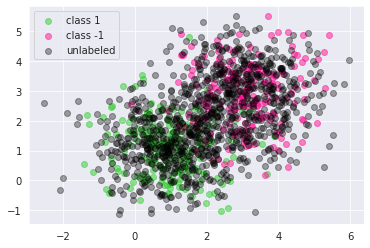

In [ ]:
# Labeled Samples
n_labeled = 400
l1 = np.random.normal(loc=1, scale=1, size=(int(n_labeled/2), 2))   # ~ N(1,1)   # label  1
l2 = np.random.normal(loc=3, scale=1, size=(int(n_labeled/2), 2))   # ~ N(3,1)   # label -1
l = np.concatenate((l1,l2),axis=0)

labels = np.ones((len(l1),1))
labels = np.concatenate((labels, -np.ones((len(l2),1))), axis=0)

# Unlabeled Samples
n_unlabeled = 1000
u1 = np.random.normal(loc=1, scale=1, size=(int(n_unlabeled/2), 2))  # ~ N(1,1)
u2 = np.random.normal(loc=3, scale=1, size=(int(n_unlabeled/2), 2))  # ~ N(3,1)
u = np.concatenate((u1,u2),axis=0)

# Target labels
y_true = np.ones((len(u), 1))
y_true[int(n_unlabeled/2):] = -1

# Initial Random Point
y = np.random.rand(len(u),1)  # random points in [0,1]
y[y>0.5] = 1
y[y<=0.5] = -1

# Graphical representation
plt.scatter(l1[:, 0], l1[:, 1], alpha=0.5, c='limegreen')
plt.scatter(l2[:, 0], l2[:, 1], alpha=0.5, c='deeppink')
plt.scatter(u1[:, 0], u1[:, 1], alpha=0.35, c='black')
plt.scatter(u2[:, 0], u2[:, 1], alpha=0.35, c='black')
plt.legend(['class 1','class -1','unlabeled'])
plt.show()

### Eucledian Similarity 

GD - Last iteration:  1418
BCGD cyclic - Last iteration:  1393
BCGD randomized - Last iteration:  150000




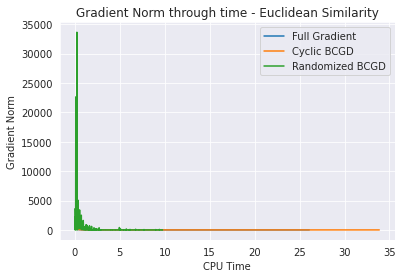



Summary table - Euclidean Similarity


,Gradient on Y,Gradient on sign(Y),Iterations,CPU time,Accuracy
GD,0.050041,110.378964,1418.0,26.073830,87.8
Cyclic,0.049926,109.723668,1393.0,33.864949,87.8
Randomized,0.304720,109.723668,150000.0,9.764973,87.8


In [ ]:
# Similarity Matrices
W = similarity(l, u, 'eu2+', spars_fact=0.8)
W_bar = similarity(u, u, 'eu2+', spars_fact=0.8)
# high spars_fact for high dimensional problems (otherwise the calculation of the gradient goes to inf)

# Gradient Norm VS CPU Time Plot
Y1, loss_history1, grad_norm_history1, time_history1, accuracy_history1 = GD(W, W_bar, y, labels, 1e-2, 2000, 5e-2, None, None)          
accuracy_history1.append(perform_accuracy(y_true, Y1))
Y2, loss_history2, grad_norm_history2, time_history2 , accuracy_history2 = BCGD_cyclic(W, W_bar, y, labels, 1e-2, 2000, 5e-2, None, None)  
accuracy_history2.append(perform_accuracy(y_true, Y2))
Y3, loss_history3, grad_norm_history3, time_history3, accuracy_history3 = BCGD_randomized(W, W_bar, y, labels, 3e-2, 150000, 1e-1000, None, None)
accuracy_history3.append(perform_accuracy(y_true, Y3))
# never calculate the loss history and accuracy history in order to not influence the CPU time of the three methods

print()
print()
plot_grad_vs_CPU('eu2+', num_step = 300)

print()
print()
summary_table('eu2+')

### Gaussian Similarity 

GD - Last iteration:  636
BCGD cyclic - Last iteration:  626
BCGD randomized - Last iteration:  150000




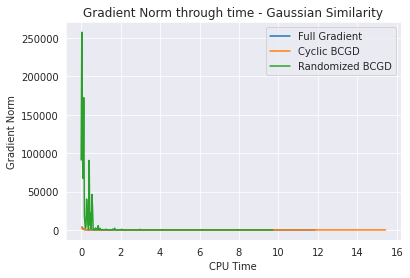



Summary table - Gaussian Similarity


,Gradient on Y,Gradient on sign(Y),Iterations,CPU time,Accuracy
GD,0.050115,660.949791,636.0,11.855323,91.9
Cyclic,0.049850,660.926313,626.0,15.426569,92.0
Randomized,0.821726,660.926313,150000.0,9.745676,92.0


In [ ]:
# Similarity Matrices
sigma = 0.8
W = similarity(l, u, 'gauss', sigma, spars_fact = 0.8) 
W_bar = similarity(u, u, 'gauss', sigma, spars_fact = 0.8)

Y1, loss_history1, grad_norm_history1, time_history1, accuracy_history1 = GD(W, W_bar, y, labels, 1e-2, 2000, 5e-2, None, None)          
accuracy_history1.append(perform_accuracy(y_true, Y1))
Y2, loss_history2, grad_norm_history2, time_history2, accuracy_history2 = BCGD_cyclic(W, W_bar, y, labels, 1e-2, 2000, 5e-2, None, None)  
accuracy_history2.append(perform_accuracy(y_true, Y2))
Y3, loss_history3, grad_norm_history3, time_history3, accuracy_history3 = BCGD_randomized(W, W_bar, y, labels, 1e-2, 150000, 1e-1000, None, None)
accuracy_history3.append(perform_accuracy(y_true, Y3))

print()
print()
plot_grad_vs_CPU('gauss', num_step = 500)

print()
print()
summary_table('gauss')

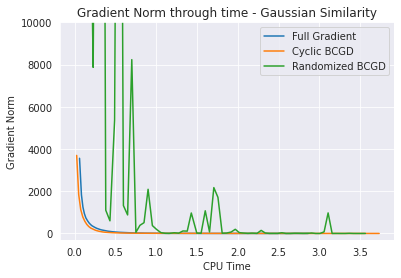

In [ ]:
  # Cropped version of the Gradient VS CPU Time Plot 
  # for a more clear distinction between GD and Cyclic BCGD
  plt.plot(time_history1[:150], grad_norm_history1[:150])
  plt.plot(time_history2[:150], grad_norm_history2[:150])
  plt.plot(time_history3[0:55000:800], grad_norm_history3[0:55000:800])
  plt.xlabel("CPU Time")
  plt.ylabel("Gradient Norm")
  plt.legend(['Full Gradient', 'Cyclic BCGD', 'Randomized BCGD'])
  plt.ylim([-300, 10000])

  plt.title('Gradient Norm through time - Gaussian Similarity')

  plt.show()

#Real dataset

link: https://archive.ics.uci.edu/ml/datasets/HTRU2#

In [ ]:
# Real-World Dataset
data = pd.read_csv('HTRU_2.csv', 
                   sep=",", 
                   na_values='?',
                   header=None)

print("Dataset length: ", len(data))

print()
data.head()

Dataset length:  17898



,0,1,2,3,4,5,6,7,8
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


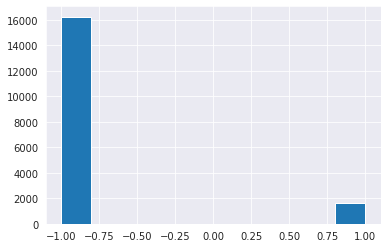

In [ ]:
# Map label 0 to -1
data.loc[data[8] == 0, 8] = -1

# Strongly Unbalanced
data[8].hist()
plt.show()

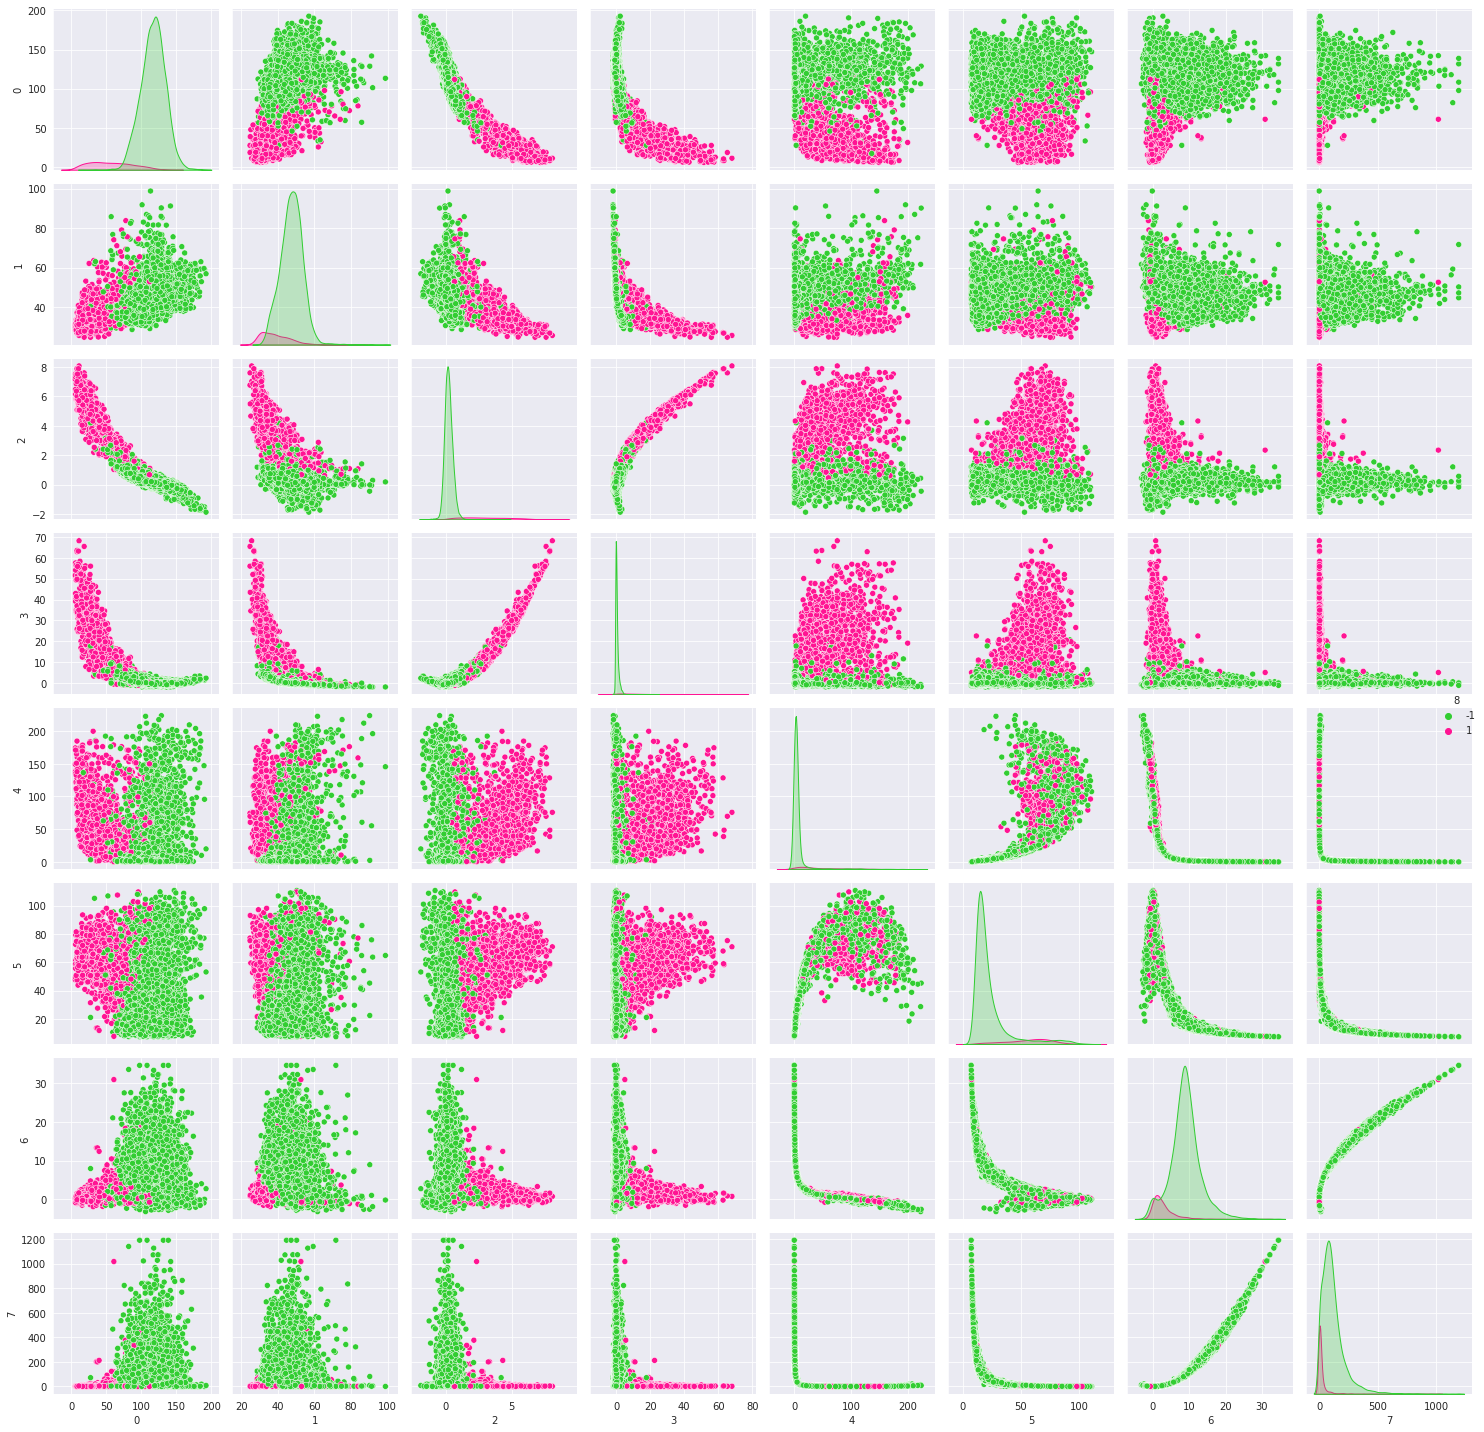

In [ ]:
# Dataset is almost linearly separable
sns.pairplot(data=data,
             palette=['limegreen','deeppink'],
             hue=8,
             vars=[0,1,2,3,4,5,6,7])
plt.tight_layout()
plt.show() 

In [ ]:
# Standardization
mean = np.mean(data.iloc[:,:-1], axis=0)
std = np.std(data.iloc[:,:-1], axis=0)

data.iloc[:,:-1] = (data.iloc[:,:-1] - mean) / std

data.head()

,0,1,2,3,4,5,6,7,8
0,1.149317,1.334832,-0.669570,-0.400459,-0.319440,-0.370625,-0.072798,-0.287438,-1
1,-0.334168,1.802265,-0.011785,-0.370535,-0.371102,-0.588924,0.504427,0.211581,-1
2,-0.314372,-1.053322,-0.145233,-0.116593,-0.322107,-0.235328,-0.125996,-0.391373,-1
3,1.000694,1.553254,-0.513409,-0.390178,-0.304404,-0.275666,-0.312265,-0.481300,-1
4,-0.871402,-0.858879,0.115609,-0.104866,-0.388010,-0.763111,1.324026,1.386794,-1


In [ ]:
# Number of samples labeled as 1 
class_1 = data[data[8] == 1]
print("Length of class 1: ", len(class_1))

# Number of samples labeled as -1
class_2 = data[data[8] == -1]
print("Length of class -1: ", len(class_2))

# Consider 800 Labeled data 
l1 = class_1.iloc[:400, :-1].to_numpy()  
l2 = class_2.iloc[:400, :-1].to_numpy()
l = np.concatenate((l1, l2)) # circa il 30% del dataset
print("Length of labled data: ", len(l))

labels = np.ones((len(l), 1))
labels[400:] = -1

# Consider 1500 Unlabeled data
u1 = class_1.iloc[400:1150, :-1].to_numpy()
u2 = class_2.iloc[400:1150, :-1].to_numpy()
u = np.concatenate((u1, u2)) # circa il 70% del dataset
print("Length of unlabled data: ", len(u))

# Target labels
y_true = np.ones((len(u), 1))
y_true[750:] = -1


Length of class 1:  1639
Length of class -1:  16259
Length of labled data:  800
Length of unlabled data:  1500


### Euclidean Similarity 

In [ ]:
# Similarity matrices
W = similarity(l, u, 'eu2+', spars_fact = 0.6)
W_bar = similarity(u, u, 'eu2+', spars_fact = 0.6)

# Starting point
y = np.random.rand(len(u), 1)
y[y>0.5] = 1
y[y<=0.5] = -1

GD - Last iteration:  582
BCGD cyclic - Last iteration:  578
BCGD randomized - Last iteration:  250000


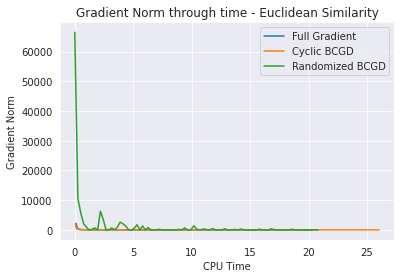



Summary table - Euclidean Similarity


,Gradient on Y,Gradient on sign(Y),Iterations,CPU time,Accuracy
GD,0.501224,238.532691,582.0,20.239468,89.40
Cyclic,0.499610,238.322534,578.0,26.041864,89.47
Randomized,3.135075,238.837030,250000.0,20.924149,88.40


In [ ]:
################ Performance evaluations WITHOUT calculation of loss history and accuracy history for each iteration ################
Y1, loss_history1, grad_norm_history1, time_history1, accuracy_history1 = GD(W, W_bar, y, labels, 1e-2, 10000, 5e-1, None, None)
accuracy_history1.append(perform_accuracy(y_true, Y1))
Y2, loss_history2, grad_norm_history2, time_history2, accuracy_history2 = BCGD_cyclic(W, W_bar, y, labels, 1e-2, 10000, 5e-1, None, None)
accuracy_history2.append(perform_accuracy(y_true, Y2))
Y3, loss_history3, grad_norm_history3, time_history3, accuracy_history3 = BCGD_randomized(W, W_bar, y, labels, 1e-2, 250000, 1e-100000, None, None)
accuracy_history3.append(perform_accuracy(y_true, Y3)) 

plot_grad_vs_CPU('eu2+', num_step = 3000)
print()
print()
summary_table('eu2+')

GD - Last iteration:  582
BCGD cyclic - Last iteration:  578
BCGD randomized - Last iteration:  200000


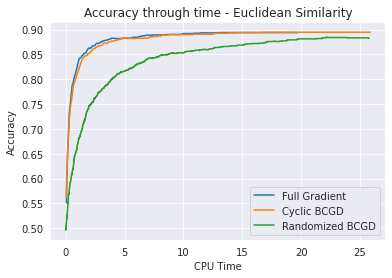

In [ ]:
################ Performance evaluations with accuracy history for each iteration ################
Y1, loss_history1, grad_norm_history1, time_history1, accuracy_history1 = GD(W, W_bar, y, labels, 1e-2, 10000, 5e-1, None, y_true)
Y2, loss_history2, grad_norm_history2, time_history2, accuracy_history2 = BCGD_cyclic(W, W_bar, y, labels, 1e-2, 10000, 5e-1, None, y_true)
Y3, loss_history3, grad_norm_history3, time_history3, accuracy_history3 = BCGD_randomized(W, W_bar, y, labels, 1e-2, 200000, 1e-100000, None, y_true)
plot_accuracy_vs_CPU('eu2+')

### Gaussian Similarity

In [ ]:
W_gauss = similarity(l, u, 'gauss', 0.8, spars_fact=0.8)
W_bar_gauss = similarity(u, u, 'gauss', 0.8,  spars_fact=0.8)

GD - Last iteration:  541
BCGD cyclic - Last iteration:  537
BCGD randomized - Last iteration:  200000


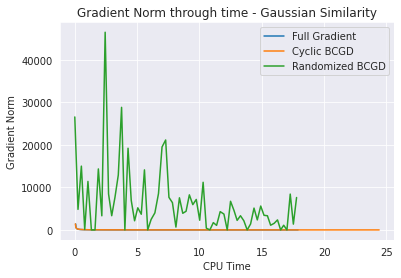



Summary table - Gaussian Similarity


,Gradient on Y,Gradient on sign(Y),Iterations,CPU time,Accuracy
GD,0.500934,304.203613,541.0,17.908312,84.80
Cyclic,0.499849,303.819035,537.0,24.413912,84.80
Randomized,205.816299,436.209514,200000.0,17.958603,70.93


In [ ]:
################ Performance evaluation WITHOUT calculation of loss history and accuracy history for each iteration ##########
Y1, loss_history1, grad_norm_history1, time_history1, accuracy_history1 = GD(W_gauss, W_bar_gauss, y, labels, 1e-2, 10000, 5e-1, None, None)
accuracy_history1.append(perform_accuracy(y_true, Y1))
Y2, loss_history2, grad_norm_history2, time_history2, accuracy_history2 = BCGD_cyclic(W_gauss, W_bar_gauss, y, labels, 1e-2, 10000, 5e-1, None, None)
accuracy_history2.append(perform_accuracy(y_true, Y2))
Y3, loss_history3, grad_norm_history3, time_history3, accuracy_history3 = BCGD_randomized(W_gauss, W_bar_gauss, y, labels, 1e-3, 200000, 1e-100000, None, None)
accuracy_history3.append(perform_accuracy(y_true, Y3)) #Can't find a better step size for the BCGD Randomized

plot_grad_vs_CPU('gauss', num_step = 3000)
print()
print()
summary_table('gauss')